# Forecast Verification vs ERA5 (Europe, 2m Temperature)

Compare **IFS** and **AIFS** forecasts against ERA5 reanalysis ground truth for `t2m` over Europe.

In [92]:
from pathlib import Path
import numpy as np
import xarray as xr

ifs_path = Path("data/IFS_forecast_europe.nc")
aifs_path = Path("data/AIFS_forecast_europe.nc")

assert ifs_path.exists(), f"Missing {ifs_path}"
assert aifs_path.exists(), f"Missing {aifs_path}"
print("Forecast files found")

Forecast files found


## Load & Inspect Forecast Files
Both files are initialized at 2026-01-01 00:00 UTC, covering Europe at 1° resolution.

In [93]:
ds_ifs = xr.open_dataset(ifs_path)
ds_aifs = xr.open_dataset(aifs_path)
print(f"IFS - {dict(ds_ifs.sizes)}")
print(f"AIFS - {dict(ds_aifs.sizes)}")

IFS - {'time': 145, 'latitude': 41, 'longitude': 73}
AIFS - {'time': 61, 'latitude': 41, 'longitude': 73}


In [ ]:
def inspect_forecast(ds, name):
    """Print key properties of a forecast dataset for sanity checking."""
    t2m = ds["t2m"]
    lat = ds["latitude"].values
    lon = ds["longitude"].values
    times = ds["time"].values
    lat_dir = "N to S" if lat[0] > lat[-1] else "S to N"
    lon_dir = "W to E" if lon[0] < lon[-1] else "E to W"

    print(f"{name}:")
    print(f"  Grid:       {len(lat)} lat x {len(lon)} lon (1 deg)")
    print(f"  Lat:        {lat[0]:.0f} to {lat[-1]:.0f} ({lat_dir})")
    print(f"  Lon:        {lon[0]:.0f} to {lon[-1]:.0f} ({lon_dir})")
    print(f"  Timesteps:  {len(times)}")
    print(f"  Time range: {str(times[0])[:16]} to {str(times[-1])[:16]}")
    print(f"  Temp range: {float(t2m.min()):.1f} K to {float(t2m.max()):.1f} K")
    print(f"  NaN count:  {int(t2m.isnull().sum())}")
    print()

inspect_forecast(ds_ifs, "IFS")
inspect_forecast(ds_aifs, "AIFS")

# Grid alignment check
lat_match = np.array_equal(ds_ifs["latitude"].values, ds_aifs["latitude"].values)
lon_match = np.array_equal(ds_ifs["longitude"].values, ds_aifs["longitude"].values)
assert lat_match and lon_match, "Grid mismatch between IFS and AIFS"
print("IFS and AIFS grids match, no regridding needed")

## Find Overlapping Forecast Times

In [95]:
overlap_times = np.intersect1d(ds_ifs["time"].values, ds_aifs["time"].values)

print(f"IFS timesteps:  {len(ds_ifs['time'])}")
print(f"AIFS timesteps: {len(ds_aifs['time'])}")
print(f"Overlap:        {len(overlap_times)} timesteps")
print(f"First: {overlap_times[0]}")
print(f"Last:  {overlap_times[-1]}")

# Verify uniform 6-hour spacing
diffs = np.diff(overlap_times).astype("timedelta64[h]").astype(int)
print(f"Time spacing: every {diffs[0]}h (uniform: {np.all(diffs == diffs[0])})")

# Lead time in hours since forecast init
init_time = overlap_times[0]  # 2026-01-01 00:00 UTC
end_time = overlap_times[-1]

lead_hours = ((overlap_times - init_time) / np.timedelta64(1, "h")).astype(int)
print(f"Lead time range: {lead_hours[0]}h to {lead_hours[-1]}h ({lead_hours[-1]/24:.0f} days)")

IFS timesteps:  145
AIFS timesteps: 61
Overlap:        61 timesteps
First: 2026-01-01T00:00:00.000000000
Last:  2026-01-16T00:00:00.000000000
Time spacing: every 6h (uniform: True)
Lead time range: 0h to 360h (15 days)


## Load ERA5 and Align All Datasets

Load the ERA5 reanalysis, select nearest grid points to match the 1 deg forecast grid, align latitude direction, and subset to the 61 overlap times.

Note: Jan 2026 data is likely ERA5T (preliminary/near-real-time) which may see minor revisions later.

In [96]:
era5_path = Path("data/ERA5_europe.nc")
assert era5_path.exists(), f"Missing {era5_path}"

ds_era5_raw = xr.open_dataset(era5_path)
print(f"ERA5 raw: {dict(ds_era5_raw.sizes)}")

ERA5 raw: {'valid_time': 64, 'latitude': 161, 'longitude': 289}


In [97]:
# Rename CDS to time instead of valid time
if "valid_time" in ds_era5_raw.dims and "time" not in ds_era5_raw.dims:
    ds_era5_raw = ds_era5_raw.rename({"valid_time": "time"})
    print("Renamed 'valid_time' to 'time'")

# Regrid ERA5 from 0.25 to 1 deg using nearest-neighbor selection
forecast_lat = ds_ifs["latitude"]
forecast_lon = ds_ifs["longitude"]

ds_era5 = ds_era5_raw["t2m"].sel(
    latitude=forecast_lat, longitude=forecast_lon, method="nearest"
).to_dataset(name="t2m")
print(f"ERA5 regridded: {dict(ds_era5.sizes)}")

# Make sure latitude runs N->S like the forecasts
era5_lat = ds_era5["latitude"].values
if era5_lat[0] < era5_lat[-1]:
    ds_era5 = ds_era5.sortby("latitude", ascending=False)
    print("Flipped ERA5 latitude to N-to-S")
else:
    print("ERA5 latitude already N-to-S")

ds_era5 = ds_era5.sel(time=overlap_times)
print(f"ERA5 after time selection: {dict(ds_era5.sizes)}")

Renamed 'valid_time' to 'time'
ERA5 regridded: {'time': 64, 'latitude': 41, 'longitude': 73}
ERA5 latitude already N-to-S
ERA5 after time selection: {'time': 61, 'latitude': 41, 'longitude': 73}


In [ ]:
ifs_overlap = ds_ifs["t2m"].sel(time=overlap_times)
aifs_overlap = ds_aifs["t2m"].sel(time=overlap_times)
era5_overlap = ds_era5["t2m"]

# Final alignment check
assert ifs_overlap.shape == aifs_overlap.shape == era5_overlap.shape, \
    f"Shape mismatch: IFS {ifs_overlap.shape}, AIFS {aifs_overlap.shape}, ERA5 {era5_overlap.shape}"
assert np.array_equal(ifs_overlap["latitude"].values, era5_overlap["latitude"].values), "Lat mismatch"
assert np.array_equal(ifs_overlap["longitude"].values, era5_overlap["longitude"].values), "Lon mismatch"
assert np.array_equal(ifs_overlap["time"].values, era5_overlap["time"].values), "Time mismatch"

print(f"All aligned: {ifs_overlap.shape}")

## Compute Verification Metrics

For each of the 61 overlap times, compute MAE, RMSE, and R^2 over the spatial domain, comparing each forecast against ERA5.

I compute both area-weighted and unweighted metrics. On a lat-lon grid, cells near the poles are physically smaller than cells near the equator, so I use `cos(lat)` weights to give each cell influence proportional to its actual area.

In [99]:
lat_weights = np.cos(np.deg2rad(ifs_overlap.latitude))
spatial_dims = ["latitude", "longitude"]


def compute_metrics(forecast, truth, weights=None):
    """Compute MAE, RMSE, R^2 per timestep over spatial dims."""
    diff = forecast - truth

    if weights is not None:
        mae = np.abs(diff).weighted(weights).mean(dim=spatial_dims)
        mse = (diff ** 2).weighted(weights).mean(dim=spatial_dims)
        truth_mean = truth.weighted(weights).mean(dim=spatial_dims)
        ss_tot = ((truth - truth_mean) ** 2).weighted(weights).mean(dim=spatial_dims)
    else:
        mae = np.abs(diff).mean(dim=spatial_dims)
        mse = (diff ** 2).mean(dim=spatial_dims)
        truth_mean = truth.mean(dim=spatial_dims)
        ss_tot = ((truth - truth_mean) ** 2).mean(dim=spatial_dims)

    rmse = np.sqrt(mse)
    r2 = 1.0 - mse / ss_tot  # can go negative

    return mae.values, rmse.values, r2.values


# Weighted
ifs_mae_w, ifs_rmse_w, ifs_r2_w = compute_metrics(ifs_overlap, era5_overlap, weights=lat_weights)
aifs_mae_w, aifs_rmse_w, aifs_r2_w = compute_metrics(aifs_overlap, era5_overlap, weights=lat_weights)

# Unweighted
ifs_mae_u, ifs_rmse_u, ifs_r2_u = compute_metrics(ifs_overlap, era5_overlap)
aifs_mae_u, aifs_rmse_u, aifs_r2_u = compute_metrics(aifs_overlap, era5_overlap)

lead_days = lead_hours / 24.0

print(f"IFS  weighted MAE: {ifs_mae_w[0]:.3f} -> {ifs_mae_w[-1]:.3f} K")
print(f"AIFS weighted MAE: {aifs_mae_w[0]:.3f} -> {aifs_mae_w[-1]:.3f} K")

IFS  weighted MAE: 0.800 -> 2.895 K
AIFS weighted MAE: 0.631 -> 3.937 K


In [100]:
# Sanity checks, ensure that the starting state is close to the actual state
print(f"  IFS:  MAE={ifs_mae_w[0]:.3f}K, RMSE={ifs_rmse_w[0]:.3f}K, R2={ifs_r2_w[0]:.4f}")
print(f"  AIFS: MAE={aifs_mae_w[0]:.3f}K, RMSE={aifs_rmse_w[0]:.3f}K, R2={aifs_r2_w[0]:.4f}")

assert ifs_mae_w[0] < 2.0 and aifs_mae_w[0] < 2.0, "t=0 MAE too large, check alignment"
assert ifs_mae_w[-1] > ifs_mae_w[0], "IFS error should grow with lead time"
assert aifs_mae_w[-1] > aifs_mae_w[0], "AIFS error should grow with lead time"
assert not any(np.isnan(x).any() for x in [
    ifs_mae_w, ifs_rmse_w, ifs_r2_w, aifs_mae_w, aifs_rmse_w, aifs_r2_w
]), "NaN in metrics"

print("All checks passed")

  IFS:  MAE=0.800K, RMSE=1.228K, R2=0.9845
  AIFS: MAE=0.631K, RMSE=0.991K, R2=0.9899
All checks passed


## Plotting

Three-panel plot: MAE, RMSE, R^2 vs lead time. Solid lines are area-weighted, dashed are unweighted.

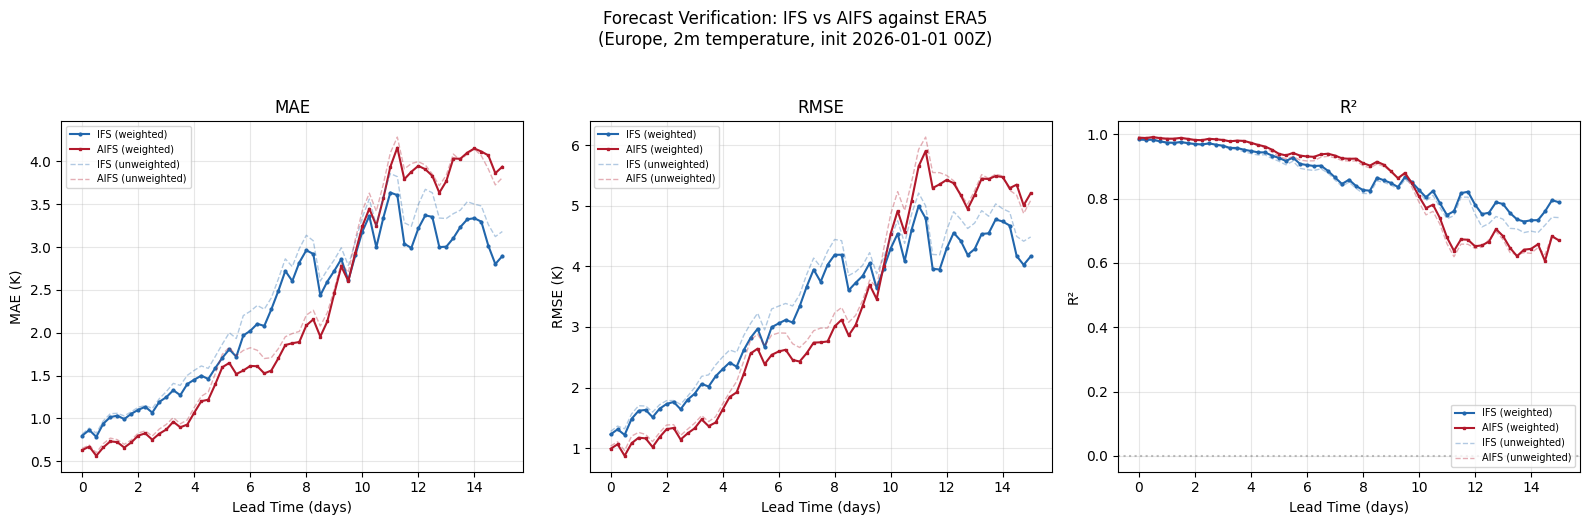

In [101]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
ifs_c, aifs_c = "#2166ac", "#b2182b"

panels = [
    ("MAE",  "MAE (K)", ifs_mae_w, aifs_mae_w, ifs_mae_u, aifs_mae_u, False),
    ("RMSE", "RMSE (K)", ifs_rmse_w, aifs_rmse_w, ifs_rmse_u, aifs_rmse_u, False),
    ("R²",   "R²",      ifs_r2_w,  aifs_r2_w,  ifs_r2_u,  aifs_r2_u,  True),
]

for ax, (title, ylabel, iw, aw, iu, au, show_zero) in zip(axes, panels):
    ax.plot(lead_days, iw, "-o", color=ifs_c,  ms=2, lw=1.5,
            label="IFS (weighted)")
    ax.plot(lead_days, aw, "-s", color=aifs_c, ms=2, lw=1.5,
            label="AIFS (weighted)")
    ax.plot(lead_days, iu, "--", color=ifs_c,  alpha=0.35, lw=1, label="IFS (unweighted)")
    ax.plot(lead_days, au, "--", color=aifs_c, alpha=0.35, lw=1, label="AIFS (unweighted)")

    if show_zero:
        ax.axhline(0, color="gray", ls=":", alpha=0.5)

    ax.set_xlabel("Lead Time (days)")
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # R² legend in bottom-right since values decrease and others use default
    if title == "R²":
        ax.legend(fontsize=7, loc="lower right")
    else:
        ax.legend(fontsize=7)

    ax.grid(True, alpha=0.3)

fig.suptitle(
    "Forecast Verification: IFS vs AIFS against ERA5\n"
    "(Europe, 2m temperature, init 2026-01-01 00Z)",
    fontsize=12, y=1.04,
)
plt.tight_layout()
plt.savefig("results.png", dpi=150, bbox_inches="tight")
plt.savefig("results.pdf", bbox_inches="tight")
plt.show()

## Interpretation

Both forecasts show error growing with lead time, as expected. AIFS starts more accurate (MAE of 0.63K vs IFS's 0.80K at initialization), but its error grows faster, reaching 3.94K by day 15. IFS error grows more steadily, only reaching 2.89K. This pattern is consistent across all three metrics, with a crossover around day 10 where IFS becomes the better model.

This makes sense since AIFS is ML-based and trained on ERA5 data, so it sits closer to ERA5 early on. IFS, being physics-based, constrains error growth better at longer lead times.

R^2 starts near 0.99 for both models and drops to 0.79 (IFS) / 0.67 (AIFS) by day 15. Both stay well above zero, so the large-scale spatial pattern (warm south, cold north) is still captured at 15 days, even though finer details are lost.

Weighted vs unweighted metrics diverge visibly because the domain spans 33N to 73N. The cos(lat) correction reduces the influence of small high-latitude cells where errors tend to be larger (more active weather).

There's also a noticeable diurnal oscillation in the error curves, with both models verifying better at nighttime.